# DonorSearch. Анализ данных НКО

_______
**Цели проекта:**
- увеличить количество доноров;
- Вовлекать больше существующих доноров

**Задачи проекта:**
- анализ поведения доноров;
- оценка влияния событий на регистрацию новых и вовлечение существующих доноров;
- создание презентации для заказчика.

*В тетради представлена часть группового проекта.*

**Содержание:**
1. Предобработка датафреймов с  бонусами и с пользователями;
2. Анализ того, какие партнеры более эффективны с точки зрения привлечения пользователей и привлечения пожертвований;
3. Рассчет процента доноров, воспользовавшихся бонусами, от общего количества зарегистрировавшихся активных доноров;
4. Проверка гипотезы "увеличение количества доноров с появлением бонуса - Яндекс Плюс";
5. Проверка гипотезы "пользователи из регионов менее вовлечены в сдачу крови чем жители столицы и областных центров";
6. Проверка гипотезы "чем выше медианная заработная плата в регионе - тем ниже количество доноров на 1000 человек".

_______

## 1. Предобработка данных



---


По итогам предобработки **датафрейма с бонусами user_bonus_anon 13.11.23.csv**:
- переименованы столбцы (с кириллицы на латиницу)
- даты использования бонуса - тип данных скорректирован
- удалены дубликаты
- обработаны столбца со страной, регионом, городом
- датасет очищен от "зарубежных" бонусов
- названия партнеров очищены от ошибок
- удалены бонусы, у которых не указана дата выдачи
- столбец с датой выдачи бонуса приведен к формату даты

Предобработанный датафрейм содержит 20579 строк, пропусков нет.



---


По итогам предобработки **датафрейма с пользователями users_anon_data 23_11.csv**:

- переименованы столбцы (с кириллицы на латиницу)
- даты - тип данных скорректирован
- дубликаты не обнаружены
- созданы дополнительные отдельные столбцы со страной и регионом
- датасет очищен от "зарубежных" пользователей
- в столбцах, где это возможно, заменены значения "да" и "нет" на булевы значения True и False
- создан отдельный столбец с годом рождения пользователя
- у пользователей с аномальными датами рождения - дата рождения заменена на "Не указано"
- удален лишний столбец donations_prereg, в столбце donations_reg - скорректирован формат данных

Предобработанный датафрейм содержит 147508 строк, пропуски остались в столбце donations_prereg, в остальных столбцах они либо отсутствуют, либо (в столбцах пол, дата рождения, тип крови, келл-фактор, последняя активность на сайте) прикрыты заглушкой "Не указано".


---



In [1]:
# Импорт библиотек, настройка вывода данных

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats as st

pd.set_option('display.max_columns', 40)
#pd.set_option('display.max_rows', None)

In [2]:
# Датафрейм с бонусами
user_bonus = pd.read_csv('\\user_bonus_anon 13.11.23.csv')

# Датафрейм с пользователями сайта
users = pd.read_csv('\\users_anon_data 23_11.csv')

### 1.1. Обработка датафрейма с бонусами user_bonus_anon 13.11.23.csv

#### 1.1.1. Общая информация об исходном датафрейме

In [3]:
# Выводим информацию о датафрейме
user_bonus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20673 entries, 0 to 20672
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID пользователя            20673 non-null  int64 
 1   Количество взятых бонусов  20673 non-null  int64 
 2   Количество донаций         20673 non-null  int64 
 3   Название партнера          20673 non-null  object
 4   Бонус                      20673 non-null  object
 5   Дата использования         20673 non-null  object
 6   Страна                     20668 non-null  object
 7   Регион                     15315 non-null  object
 8   Город                      20668 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.4+ MB


1) название столбцов на кириллице - лучше переименовать

2) больше всего пропусков в столбце с регионом - надо проверить (может, это Мск и Спб и указаны в столбце города)

3) есть небольшое количество пропусков в столбцах со страной и городом

4) типы данных указаны точно, кроме даты

5) в датасете 20673 строки



#### 1.1.2. Переименование столбцов

In [4]:
# Переименование столбцов

user_bonus = user_bonus.rename(
  columns={
    'ID пользователя': 'user_id',
    'Количество взятых бонусов': 'bonus_count',
    'Количество донаций': 'donations_count',
    'Название партнера': 'partner',
    'Бонус': 'bonus_type',
    'Дата использования': 'date_used',
    'Страна': 'country',
    'Регион': 'region',
    'Город': 'city',
  }
)

In [5]:
# Вывод названий столбцов после переименования

user_bonus.columns

Index(['user_id', 'bonus_count', 'donations_count', 'partner', 'bonus_type',
       'date_used', 'country', 'region', 'city'],
      dtype='object')



---

Столбцы переименованы успешно

---



#### 1.1.3. Поиск и удаление дубликатов

In [6]:
# Поиск полных дубликатов

user_bonus[user_bonus.duplicated()]

,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
10518,7479,5,46,МИФ,"Книга от МИФ ""Лучше с каждым днем"" - в подарок",20.09.2022,Россия,Московская область,Красногорск
10519,150535,86,24,МИФ,"Книга от МИФ ""Лучше с каждым днем"" - в подарок",20.09.2022,Россия,NaN,Москва
10520,154903,7,6,МИФ,"Книга от МИФ ""Лучше с каждым днем"" - в подарок",20.09.2022,Россия,NaN,Москва




---

Обнаружено 3 полных дубликата, удаляем

---



In [7]:
# Удаление дубликатов

user_bonus = user_bonus.drop_duplicates()

In [8]:
# Вывод информации о датасете после удаления дубликатов

user_bonus.info()
user_bonus.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20670 entries, 0 to 20672
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          20670 non-null  int64 
 1   bonus_count      20670 non-null  int64 
 2   donations_count  20670 non-null  int64 
 3   partner          20670 non-null  object
 4   bonus_type       20670 non-null  object
 5   date_used        20670 non-null  object
 6   country          20665 non-null  object
 7   region           15314 non-null  object
 8   city             20665 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.6+ MB


,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
0,132667,15,44,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",23.10.2023,Россия,NaN,Санкт-Петербург
1,224412,14,31,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",23.10.2023,Россия,Татарстан,Казань
2,153877,33,53,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",23.10.2023,Россия,Ивановская область,Вичуга


#### 1.1.4. Обработка столбцов со страной, регионом, городом

In [9]:
# Выводим уникальные значения городов по строкам, где не указан регион

user_bonus[user_bonus['region'].isna()]['city'].unique()

array(['Санкт-Петербург', 'Москва', 'Ташкент', 'Алма-Ата', nan,
       'Тирасполь', 'Бишкек'], dtype=object)

In [10]:
# Выводим уникальные значения стран

user_bonus['country'].unique()

array(['Россия', 'Украина', '_', 'Узбекистан', 'Казахстан', nan,
       'Беларусь', 'Молдова', 'Кыргызстан'], dtype=object)

##### Обработка строк с городами Москва и Санкт-Петербург

In [11]:
# Проверка предположения о том, что регион пропущен, в том числе, в строках, где города - Москва и Санкт-Петербург

user_bonus.query('(region.isna()) & (city == ["Москва", "Санкт-Петербург"])')

,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
0,132667,15,44,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",23.10.2023,Россия,NaN,Санкт-Петербург
3,225324,14,9,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",22.10.2023,Россия,NaN,Москва
5,180949,13,3,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",20.10.2023,Россия,NaN,Санкт-Петербург
6,167490,27,12,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",20.10.2023,Россия,NaN,Москва
9,229245,10,17,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",19.10.2023,Россия,NaN,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...
20665,144038,1,2,4Fresh,-10% на весь ассортимент,27.10.2021,Россия,NaN,Санкт-Петербург
20667,168414,6,1,4Fresh,-10% на весь ассортимент,08.10.2021,Россия,NaN,Санкт-Петербург
20670,361,1,3,4Fresh,-10% на весь ассортимент,17.01.2021,Россия,NaN,Москва
20671,137181,1,3,4Fresh,-10% на весь ассортимент,04.01.2021,Россия,NaN,Москва




---

В датасете 5335 таких строк

---



In [12]:
# Исходя из анализа, регион пропущен в строках, где города - Москва и Спб; укажем а таких строках регион, соответствующий городу (это города федерального значения)

user_bonus['region'] = np.where(user_bonus['city'] == 'Москва', 'Москва', user_bonus['region'])
user_bonus['region'] = np.where(user_bonus['city'] == 'Санкт-Петербург', 'Санкт-Петербург', user_bonus['region'])

##### Обработка строк с пропусками в стране

In [13]:
# Выводим строки с пропусками в стране

user_bonus[user_bonus['country'].isna()]

,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
5374,227549,3,3,Яндекс Плюс,2 месяца подписки Яндекс Плюс бесплатно,29.03.2023,NaN,NaN,NaN
11118,224215,1,1,Farfor,Пицца бесплатно на Farfor.ru,06.10.2022,NaN,NaN,NaN
14527,227549,3,3,Ozon,Подписка Ozon Premium на 1 месяц,27.10.2022,NaN,NaN,NaN
17768,193542,1,0,Другое Дело,6000 баллов на платформе Другое Дело,30.03.2022,NaN,NaN,NaN
20067,227549,3,3,Lamoda,-15% на товары,03.11.2022,NaN,NaN,NaN


In [14]:
# Выводим строки с пропусками в городе

user_bonus[user_bonus['city'].isna()]

,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
5374,227549,3,3,Яндекс Плюс,2 месяца подписки Яндекс Плюс бесплатно,29.03.2023,NaN,NaN,NaN
11118,224215,1,1,Farfor,Пицца бесплатно на Farfor.ru,06.10.2022,NaN,NaN,NaN
14527,227549,3,3,Ozon,Подписка Ozon Premium на 1 месяц,27.10.2022,NaN,NaN,NaN
17768,193542,1,0,Другое Дело,6000 баллов на платформе Другое Дело,30.03.2022,NaN,NaN,NaN
20067,227549,3,3,Lamoda,-15% на товары,03.11.2022,NaN,NaN,NaN




---

В строках с пропусками в стране, пропущены и значения региона, и города

---



In [15]:
# Удаляем строки, где в трех столбцах страна-регион-город пропуски

user_bonus = user_bonus.loc[~user_bonus['city'].isna()]

##### Обработка строк с прочерками в стране

In [16]:
# Выводим строки с прочерками "_" в стране

user_bonus[user_bonus['country'] == "_"]

,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
285,273142,2,2,Farfor,Пицца бесплатно на Farfor.ru,30.10.2023,_,Луганская область,Луганск
1421,149168,1,15,Литрес,DonorSearch и Литрес дарят подарки!,26.09.2023,_,Донецкая область,Донецк
6332,157681,2,41,More.TV,45 дней подписки в подарок,05.08.2023,_,Луганская область,Луганск
8742,273142,2,2,Другое Дело,6000 баллов на платформе Другое Дело,30.10.2023,_,Луганская область,Луганск
12242,201263,2,1,Яндекс Плюс,2 месяца подписки Яндекс Плюс бесплатно,25.07.2022,_,Луганская область,Луганск
12898,157681,2,41,Utair,250 миль от Utair,19.12.2022,_,Луганская область,Луганск
16092,201263,2,1,Яндекс Плюс,2 месяца подписки Яндекс Плюс бесплатно,28.04.2022,_,Луганская область,Луганск




---

Прочерки выставлены в стране в строках, где регион - Луганская и Донецкая области

---



In [17]:
# Прочерки в стране по тем бонусам, которые выданы в Донецке и Луганске, заполняем Россией

user_bonus['country'] = np.where((user_bonus['city'] == 'Луганск') | (user_bonus['city'] == 'Донецк'), 'Россия', user_bonus['country'])



---


1) Пропуски во всех трех столбцах страна-регион-город остались в 5 строках - они удалены, т.к. потеря этих строк не исказит общую картину

2) пропуски в столбце "регион" в основном в зарубежных странах - Казахстан, Узбекистан, Кыргызстан, Молдова. С этими пропусками можно ничего не делать, указание региона в этих случаях вряд ли влияет на анализ (таких строк немного, и вряд ли будет анализ "зарубежных" бонусов в разрезе региона).
Кроме того, заполнены пропуски по Москве и Санкт-Петербургу

3) Прочерки в стране по тем бонусам, которые выданы в Донецке и Луганске, заполним Россией, для целей анализа.


---



#### 1.1.5. Очистка датафрейма от информации из зарубежных стран

In [18]:
# Оставляем в датафрейме только бонусы, выданные в России

user_bonus = user_bonus.loc[user_bonus['country'] == 'Россия']



---


На этапе предобработки в ходе командной работы было принято предложение убрать из анализа зарубежные страны


---



#### 1.1.6. Обработка значений столбца с партнерами

In [19]:
# Выводим уникальные значения столбца с партнерами

user_bonus['partner'].unique()

array(['МИФ', 'Билайн тв', 'Farfor', 'Подписка Газпром Бонус', 'Литрес',
       'МТС Premium', 'Веганский магазин Веги Вуги', 'Самокат', 'Lectr',
       'Flowwow', 'Казанский театр юного зрителя',
       'MOÑ | театральная площадка', 'Творческая лаборатория «Угол»',
       'Особняк Демидова', 'фитнес-клуб Атом', 'Яндекс Плюс', 'More.TV',
       'Cash Flow', 'Puzzle English', 'Alter',
       '\u200bКлиника Майндсет\u200b', '#SEKTA', 'Другое Дело',
       'Hobby Games', 'Qlean', 'Ветеринарная клиника Dr.Pet’s',
       'Tasty Coffee', 'ОНКОСТРАХОВАНИЕ', 'Gymmy',
       'Экомаркет Low Waste Казань', 'Сеть сайкл-студий VELOBEAT',
       'CITY SQUASH', 'Bookmate', 'Квиз Эйнштейн Party', 'Utair',
       'MTS Music', 'АРТ-МАТИТА', 'Bonnie&Slide', 'Rock the Cycle',
       'Wave Hunters', 'НянЯрядом', 'REBOOT', 'Экомаркет',
       'Соляная пещера Кристалл', 'Гусьгусь', 'Arzamas', 'ГМИИ РТ',
       'Ozon', 'Массажная студия Habitat\u200b', 'Альпина Паблишер',
       'Skillbox', 'GEN.RU', 'Gett', 



---

В названиях некоторых партнеров встречаются лишние сиволы "\u200b", удалим их. Также название партнера 'Подписка Газпром Бонус' явно спутана с названием самого бонуса, скорректируем этот момент.

---



In [20]:
# Удаляем лишние символы из названий партнеров

user_bonus['partner'] = user_bonus['partner'].replace("\u200b", "", regex=True)

In [21]:
# Корректировка названия партнера Газпромнефть

user_bonus.loc[user_bonus['partner'] == 'Подписка Газпром Бонус', 'partner'] = 'Газпромнефть'

#### 1.1.7. Очистка датафрейма от пустых значений в столбце с датой получения бонуса

In [22]:
print('Всего пустых значений в столбце с датой получения бонуса:', len(user_bonus[user_bonus['date_used'] == 'Не указано']))

Всего пустых значений в столбце с датой получения бонуса: 12


In [23]:
# Всего 12 пустых значений из всего датафрейма - можно удалить без ущерба для анализа

user_bonus = user_bonus.loc[~(user_bonus['date_used'] == 'Не указано')]

#### 1.1.8. Корректировка типов данных в столбцах

In [24]:
# Изменение типа данных в столбце с датой использования бонуса

user_bonus['date_used'] = pd.to_datetime(user_bonus['date_used'], format='%d.%m.%Y')

#### 1.1.9. Информация о предобработанном датафрейме с бонусами

In [25]:
user_bonus.info()
user_bonus.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20579 entries, 0 to 20672
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          20579 non-null  int64         
 1   bonus_count      20579 non-null  int64         
 2   donations_count  20579 non-null  int64         
 3   partner          20579 non-null  object        
 4   bonus_type       20579 non-null  object        
 5   date_used        20579 non-null  datetime64[ns]
 6   country          20579 non-null  object        
 7   region           20579 non-null  object        
 8   city             20579 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.6+ MB


,user_id,bonus_count,donations_count,partner,bonus_type,date_used,country,region,city
0,132667,15,44,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-23,Россия,Санкт-Петербург,Санкт-Петербург
1,224412,14,31,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-23,Россия,Татарстан,Казань
2,153877,33,53,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-23,Россия,Ивановская область,Вичуга
3,225324,14,9,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-22,Россия,Москва,Москва
4,269612,4,3,МИФ,"Книга от МИФ ""Болезни отменяются"" в подарок",2023-10-22,Россия,Омская область,Омск




---
По итогам предобработки:
- переименованы столбцы (с кириллицы на латиницу)
- даты использования бонуса - тип данных скорректирован
- удалены дубликаты
- обработаны столбца со страной, регионом, городом
- датасет очищен от "зарубежных" бонусов
- названия партнеров очищены от ошибок
- удалены бонусы, у которых не указана дата выдачи
- столбец с датой выдачи бонуса приведен к формату даты

Предобработанный датафрейм содержит 20579 строк

---




### 1.2. Обработка датафрейма с пользователями users_anon_data 23_11.csv

#### 1.2.1. Общая информация об исходном датафрейме

In [26]:
# Выводим информацию о датафрейме с пользователями сайта

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265474 entries, 0 to 265473
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   ID                               265474 non-null  int64 
 1   Пол                              265474 non-null  object
 2   Дата рождения                    265474 non-null  object
 3   Регион                           265474 non-null  object
 4   Группа крови                     265474 non-null  object
 5   Kell-фактор                      265474 non-null  object
 6   Цельная кровь                    265474 non-null  object
 7   Плазма                           265474 non-null  object
 8   Тромбоциты                       265474 non-null  object
 9   Эритроциты                       265474 non-null  object
 10  Лейкоциты                        265474 non-null  object
 11  Костный мозг                     265474 non-null  object
 12  Почетный донор  

,ID,Пол,Дата рождения,Регион,Группа крови,Kell-фактор,Цельная кровь,Плазма,Тромбоциты,Эритроциты,Лейкоциты,Костный мозг,Почетный донор,Отвод от донации,Цельная кровь.1,Плазма.1,Тромбоциты.1,Эритроциты.1,Лейкоциты.1,Дата регистрации,Не подтверждённые донации,Прошедших донаций,Донаций до регистрации,Последняя активность,Теги,Указан email,Указан телефон,Авторизация через ВК,Авторизация через Одноклассники,Авторизация через Твиттер,Авторизация через Яндекс,Авторизация через Гугл,Подтверждённые донации,Получен значок 20,Получен значок 100,Донаций на момент регистрации,Количество взятых бонусов
0,275790,Не указано,Не указано,"Россия, Кемеровская область, Мыски",O(I) Rh-,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,23.11.2023,0,0,Не указано,23.11.2023,['DirectSignUp'],нет,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0
1,275789,Женский,09.03.2005,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,23.11.2023,0,0,Не указано,Не указано,['CardsMobile'],да,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0
2,275788,Не указано,Не указано,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,23.11.2023,0,0,Не указано,23.11.2023,['Blood'],нет,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0
3,275787,Мужской,29.04.1977,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,23.11.2023,0,0,32,23.11.2023,['MainPage'],да,да,нет,нет,нет,да,нет,0,нет,нет,32,0
4,275786,Не указано,Не указано,"Россия, Москва",O(I) Rh+,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,23.11.2023,0,0,2,23.11.2023,['MainPage'],да,нет,да,нет,нет,нет,нет,0,нет,нет,2,0




---
1) название столбцов на кириллице - лучше переименовать

2) пропуски (явные, NaN) отсутствуют

4) типы данных требуют корректировки (в т.ч. даты, булевы значения и тп)

5) в датасете 265 474 строки


---



#### 1.2.2. Переименование столбцов

In [27]:
# Переименование столбцов

users = users.rename(
  columns={
    'ID': 'user_id',
    'Пол': 'gender',
    'Дата рождения': 'birth_date',
    'Регион': 'location',
    'Группа крови': 'blood_type',
    'Kell-фактор': 'kell_factor',
    'Цельная кровь': 'whole_blood',
    'Плазма': 'plasma',
    'Тромбоциты': 'thrombocytes',
    'Эритроциты': 'erythrocytes',
    'Лейкоциты': 'leukocytes',
    'Костный мозг': 'bone_marrow',
    'Почетный донор': 'honor_donor',
    'Отвод от донации': 'exception',
    'Цельная кровь.1': 'whole_blood_1',
    'Плазма.1': 'plasma_1',
    'Тромбоциты.1': 'thrombocytes_1',
    'Эритроциты.1': 'erythrocytes_1',
    'Лейкоциты.1': 'leukocytes_1',
    'Дата регистрации': 'reg_date',
    'Не подтверждённые донации': 'donations_unconfirmed',
    'Прошедших донаций': 'donations_successful',
    'Донаций до регистрации': 'donations_prereg',
    'Последняя активность': 'last_activity',
    'Теги': 'tags',
    'Указан email': 'email_indicated',
    'Указан телефон': 'phone_indicated',
    'Авторизация через ВК': 'vk_auth',
    'Авторизация через Одноклассники': 'ok_auth',
    'Авторизация через Твиттер': 'twitter_auth',
    'Авторизация через Яндекс': 'yandex_auth',
    'Авторизация через Гугл': 'google_auth',
    'Подтверждённые донации': 'donations_confirmed',
    'Получен значок 20': 'badge_20',
    'Получен значок 100': 'badge_100',
    'Донаций на момент регистрации': 'donations_reg',
    'Количество взятых бонусов': 'bonus_count'
  }
)

In [28]:
# Вывод названий столбцов после переименования

users.columns

Index(['user_id', 'gender', 'birth_date', 'location', 'blood_type',
       'kell_factor', 'whole_blood', 'plasma', 'thrombocytes', 'erythrocytes',
       'leukocytes', 'bone_marrow', 'honor_donor', 'exception',
       'whole_blood_1', 'plasma_1', 'thrombocytes_1', 'erythrocytes_1',
       'leukocytes_1', 'reg_date', 'donations_unconfirmed',
       'donations_successful', 'donations_prereg', 'last_activity', 'tags',
       'email_indicated', 'phone_indicated', 'vk_auth', 'ok_auth',
       'twitter_auth', 'yandex_auth', 'google_auth', 'donations_confirmed',
       'badge_20', 'badge_100', 'donations_reg', 'bonus_count'],
      dtype='object')



---

Столбцы переименованы успешно

---

#### 1.2.3. Корректировка типов данных в столбцах

In [29]:
# Изменение типа данных в столбцах с датой

for date_col in ['birth_date', 'reg_date', 'last_activity']:
  users[date_col] = pd.to_datetime(users[date_col], format='%d.%m.%Y', errors='ignore')

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265474 entries, 0 to 265473
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                265474 non-null  int64         
 1   gender                 265474 non-null  object        
 2   birth_date             265474 non-null  object        
 3   location               265474 non-null  object        
 4   blood_type             265474 non-null  object        
 5   kell_factor            265474 non-null  object        
 6   whole_blood            265474 non-null  object        
 7   plasma                 265474 non-null  object        
 8   thrombocytes           265474 non-null  object        
 9   erythrocytes           265474 non-null  object        
 10  leukocytes             265474 non-null  object        
 11  bone_marrow            265474 non-null  object        
 12  honor_donor            265474 non-null  obje



---

Изменился тип только столбца с датой регистрации, в остальных кроме дат есть посторонние значения

---



#### 1.2.4. Поиск и удаление дубликатов

In [31]:
# Выводим строки-дубликаты

users[users.duplicated()]

,user_id,gender,birth_date,location,blood_type,kell_factor,whole_blood,plasma,thrombocytes,erythrocytes,leukocytes,bone_marrow,honor_donor,exception,whole_blood_1,plasma_1,thrombocytes_1,erythrocytes_1,leukocytes_1,reg_date,donations_unconfirmed,donations_successful,donations_prereg,last_activity,tags,email_indicated,phone_indicated,vk_auth,ok_auth,twitter_auth,yandex_auth,google_auth,donations_confirmed,badge_20,badge_100,donations_reg,bonus_count


In [32]:
# Выводим строки с дубликатами в идентификаторах пользователей

users[users.duplicated(subset='user_id')]

,user_id,gender,birth_date,location,blood_type,kell_factor,whole_blood,plasma,thrombocytes,erythrocytes,leukocytes,bone_marrow,honor_donor,exception,whole_blood_1,plasma_1,thrombocytes_1,erythrocytes_1,leukocytes_1,reg_date,donations_unconfirmed,donations_successful,donations_prereg,last_activity,tags,email_indicated,phone_indicated,vk_auth,ok_auth,twitter_auth,yandex_auth,google_auth,donations_confirmed,badge_20,badge_100,donations_reg,bonus_count




---


Полных дубликатов нет. Дублирующихся идентификаторов пользователя нет.


---



#### 1.2.5. Создание столбцов со страной и регионом

In [33]:
# Создаем столбец со страной пользователя

users['country'] = users['location'].str.split(r',\s*').str[0]

In [34]:
# Выводим уникальные значения нового столбца со странами

users['country'].unique()

array(['Россия', 'Не указано', '_', 'Казахстан', 'Украина', 'Беларусь',
       'Узбекистан', 'Молдова', 'Кыргызстан', 'Грузия', 'Таджикистан',
       'Азербайджан', 'Германия', 'США', 'Великобритания', 'Словакия',
       'Армения', 'Латвия', 'Польша', 'Финляндия', 'Япония', 'Чехия',
       'Эстония', 'Мексика', 'Израиль', 'Кипр', 'Румыния', 'Норвегия',
       'Ирак', 'Швеция', 'Монголия', 'Австрия', 'Нигер', 'Китай',
       'Объединенные Арабские Эмираты', 'Багамы', 'Греция',
       'Южно-Африканская Республика', 'Вьетнам', 'Ямайка',
       'Новая Зеландия', 'Швейцария', 'Албания', 'Кот д`Ивуар', 'Италия',
       'Пуэрто-Рико', 'Сент-Китс и Невис', 'Панама', 'Южная Корея',
       'Нидерланды', 'Бурунди', 'Литва', 'Сербия', 'Афганистан',
       'Македония', 'Бразилия', 'Камерун', 'Палестинская автономия',
       'Белиз', 'Испания', 'Австралия', 'Сент-Люсия', 'Гонконг', 'Канада',
       'Куба', 'Дания', 'Мальдивы', 'Нигерия', 'Франция', 'Ирландия',
       'Туркменистан', 'Барбадос', 'Сей

In [35]:
# Выводим строки, где в столбце страна указан прочерк "_"

users[users['country'] == '_'].head(10)

,user_id,gender,birth_date,location,blood_type,kell_factor,whole_blood,plasma,thrombocytes,erythrocytes,leukocytes,bone_marrow,honor_donor,exception,whole_blood_1,plasma_1,thrombocytes_1,erythrocytes_1,leukocytes_1,reg_date,donations_unconfirmed,donations_successful,donations_prereg,last_activity,tags,email_indicated,phone_indicated,vk_auth,ok_auth,twitter_auth,yandex_auth,google_auth,donations_confirmed,badge_20,badge_100,donations_reg,bonus_count,country
669,275085,Не указано,Не указано,"_, Запорожская область, Бердянск",A(II) Rh+,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-16,0,0,7,16.11.2023,['Blood'],да,да,нет,нет,нет,нет,нет,0,нет,нет,7,0,_
918,274828,Мужской,Не указано,"_, Донецкая область, Донецк",Не указано,Не указано,Да,Да,Да,Да,Да,Нет,21.06.2025,Нет,1,0,0,0,0,2023-11-14,0,1,1,16.11.2023,[None],да,нет,нет,нет,нет,нет,да,1,нет,нет,1,0,_
1419,274325,Не указано,Не указано,"_, Донецкая область, Донецк",Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-08,0,0,1,14.11.2023,['Blood'],да,нет,нет,нет,нет,нет,да,0,нет,нет,1,0,_
2276,273453,Женский,09.12.1985,"_, Луганская область, Ровеньки",A(II) Rh-,Не знаю,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-10-29,0,0,Не указано,29.10.2023,[None],да,нет,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0,_
2379,273345,Не указано,Не указано,"_, Луганская область, Луганск",Не указано,Отрицательный,Да,Да,Да,Да,Да,Да,Дата получения не известна,Нет,0,0,0,0,0,2023-10-27,0,0,4,27.10.2023,['MainPage'],нет,нет,да,нет,нет,нет,нет,0,нет,нет,4,0,_
2571,273142,Мужской,18.12.2000,"_, Луганская область, Луганск",AB(IV) Rh-,Не указано,Да,Да,Да,Да,Да,Нет,23.05.2025,Нет,2,0,0,0,0,2023-10-25,3,2,5,31.10.2023,['MainPage'],да,да,да,нет,нет,нет,нет,2,нет,нет,5,2,_
4805,270870,Мужской,Не указано,"_, Донецкая область, Мариуполь",O(I) Rh+,Не указано,Да,Да,Нет,Нет,Нет,Нет,09.09.2026,Нет,1,1,0,0,0,2023-10-03,0,2,500,17.11.2023,[None],да,да,да,нет,нет,нет,нет,2,нет,нет,500,0,_
8865,266711,Женский,21.09.2004,"_, Донецкая область, Макеевка",A(II) Rh+,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-08-17,0,0,0,17.08.2023,['MainPage'],да,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0,_
8899,266677,Мужской,12.09.1994,"_, Донецкая область, Мариуполь",B(III) Rh+,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-08-16,0,0,6,16.08.2023,['DirectSignUp'],да,да,нет,нет,нет,да,нет,0,нет,нет,6,0,_
9258,266303,Мужской,Не указано,"_, Донецкая область, Макеевка",A(II) Rh+,Не указано,Да,Да,Да,Да,Да,Нет,12.04.2025,Нет,2,0,0,0,0,2023-08-12,0,2,Не указано,05.10.2023,['MainPage'],да,да,нет,нет,нет,нет,нет,2,нет,нет,Не указано,0,_




---

Прочерки в стране, как и в датасете с бонусами, в строках, где регион - Донецкая или Луганская области. Поступим с ними аналогично.

---



In [36]:
# В строках, где в стране указаны прочерки, ставим страну Россия (для целей анализа)

users['country'] = np.where(users['location'].str.split(r',\s*').str[0] == '_', 'Россия', users['country'])

In [37]:
# Создаем столбец с регионом, пропуски заполняем значением "Не указано"

users['region'] = users['location'].str.split(r',\s*').str[1]

users['region'] = users['region'].fillna('Не указано')

In [38]:
# Вывод строк датафрейма для проверки создания новых столбцов

users.head(3)

,user_id,gender,birth_date,location,blood_type,kell_factor,whole_blood,plasma,thrombocytes,erythrocytes,leukocytes,bone_marrow,honor_donor,exception,whole_blood_1,plasma_1,thrombocytes_1,erythrocytes_1,leukocytes_1,reg_date,donations_unconfirmed,donations_successful,donations_prereg,last_activity,tags,email_indicated,phone_indicated,vk_auth,ok_auth,twitter_auth,yandex_auth,google_auth,donations_confirmed,badge_20,badge_100,donations_reg,bonus_count,country,region
0,275790,Не указано,Не указано,"Россия, Кемеровская область, Мыски",O(I) Rh-,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,Не указано,23.11.2023,['DirectSignUp'],нет,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0,Россия,Кемеровская область
1,275789,Женский,09.03.2005,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,Не указано,Не указано,['CardsMobile'],да,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0,Не указано,Не указано
2,275788,Не указано,Не указано,Не указано,Не указано,Не указано,Да,Да,Да,Да,Да,Нет,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,Не указано,23.11.2023,['Blood'],нет,да,нет,нет,нет,нет,нет,0,нет,нет,Не указано,0,Не указано,Не указано


#### 1.2.6 Очистка датафрейма от информации из зарубежных стран

In [39]:
# Оставляем в датафрейме только пользователей из России

users = users.loc[users['country'] == 'Россия']

In [40]:
len(users)

147508



---


На этапе предобработки в ходе командной работы было принято предложение убрать из анализа зарубежные страны.

После удаления пользователей из зарубежных стран, из 265474 строк в датасете осталось 147508 (55,6% изначального датасета) Потеря существенная, но запланированная.


---



#### 1.2.7. Замена категориальных значений в столбцах на булев

In [41]:
# Меняем в столбцах "да" и "нет" на True и False там, где это возможно

for col in (['whole_blood',
                'plasma',
                'thrombocytes',
                'erythrocytes',
                'leukocytes',
                'bone_marrow',
                'email_indicated',
                'phone_indicated',
                'vk_auth',
                'ok_auth',
                'twitter_auth',
                'yandex_auth',
                'google_auth',
                'badge_20',
                'badge_100']):
    users[col] = users[col].str.lower().map({'да': True, 'нет': False})

In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147508 entries, 0 to 265473
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                147508 non-null  int64         
 1   gender                 147508 non-null  object        
 2   birth_date             147508 non-null  object        
 3   location               147508 non-null  object        
 4   blood_type             147508 non-null  object        
 5   kell_factor            147508 non-null  object        
 6   whole_blood            147508 non-null  bool          
 7   plasma                 147508 non-null  bool          
 8   thrombocytes           147508 non-null  bool          
 9   erythrocytes           147508 non-null  bool          
 10  leukocytes             147508 non-null  bool          
 11  bone_marrow            147508 non-null  bool          
 12  honor_donor            147508 non-null  obje



---

Замена значений прошла успешно, тип данных в столбцах поменялся

---



#### 1.2.8. Обработка столбца с возрастом пользователей

In [43]:
# Приведение значений возраста пользователей к формату даты

users['birth_date'] = pd.to_datetime(users['birth_date'], format='%d.%m.%Y', errors='coerce')

In [44]:
# Создание отдельного столбца с годом рождения пользователей

users['birth_year'] = users['birth_date'].dt.year

In [45]:
# Серия операций для того, чтобы год рождения был в целочисленном формате

users['birth_year'] = (
    users['birth_year'].fillna(-1)
    .astype(int)
    .astype(object)
    .where(users['birth_year'].notnull())
)



---


В датафрейме присутствуют пользователи, указавшие в качестве даты своего рождения аномальные значения. Примем за аномалии пользователей младше 16 лет (требование законодательства) и старше 65 лет (рекомендации ВОЗ).

При этом, есть вероятность того, что дата рождения таких пользователей, указанная ими самими, может быть ошибочной в силу разных причин (неудобство заполнения формы на сайте, желание сохранить анонимность и тп).

Поэтому не будем удалять их из датафрейма, но присвоим их возрасту значение "Не указано" - чтобы не исключать из анализа.


---



In [46]:
# Присвоение пользователям "старше" 65 и "младше" 16 лет "нулевого" возраста

users.loc[(1958 > users['birth_year']) | (users['birth_year'] > 2007) | (users['birth_date'].isna()), 'birth_date'] = np.nan
users.loc[(1958 > users['birth_year']) | (users['birth_year'] > 2007) | (users['birth_date'].isna()), 'birth_year'] = np.nan

In [47]:
# Присвоение всем пользователям с "нулевым" возрастом значения возраста "Не указано"

users['birth_date'] = users['birth_date'].fillna('Не указано')
users['birth_year'] = users['birth_year'].fillna('Не указано')

#### 1.2.9. Удаление лишних столбцов

По информации от заказчика, столбцы donations_prereg и donations_reg идентичны, один из них можно удалить

In [48]:
# Удалеине столбца donations_prereg

users = users.drop(columns='donations_prereg')

In [49]:
users.head(1)

,user_id,gender,birth_date,location,blood_type,kell_factor,whole_blood,plasma,thrombocytes,erythrocytes,leukocytes,bone_marrow,honor_donor,exception,whole_blood_1,plasma_1,thrombocytes_1,erythrocytes_1,leukocytes_1,reg_date,donations_unconfirmed,donations_successful,last_activity,tags,email_indicated,phone_indicated,vk_auth,ok_auth,twitter_auth,yandex_auth,google_auth,donations_confirmed,badge_20,badge_100,donations_reg,bonus_count,country,region,birth_year
0,275790,Не указано,Не указано,"Россия, Кемеровская область, Мыски",O(I) Rh-,Не указано,True,True,True,True,True,False,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,23.11.2023,['DirectSignUp'],False,True,False,False,False,False,False,0,False,False,Не указано,0,Россия,Кемеровская область,Не указано


In [50]:
# Вывод уникальных значений столбца donations_reg

users['donations_reg'].unique()

array(['Не указано', '2', '36', '5', '3', '6', '1', '33', '11', '10', '9',
       '18', '16', '34', '70', '60', '17', '21', '13', '12', '4', '85',
       '79', '28', '25', '15', '187', '8', '30', '23', '75', '26', '44',
       '27', '20', '22', '7', '46', '29', '19', '53', '45', '31', '152',
       '55', '40', '47', '62', '94', '38', '90', '43', '14', '106', '39',
       '24', '32', '37', '51', '116', '56', '64', '54', '105', '92',
       '103', '35', '41', '61', '98', '52', '48', '99', '57', '100', '69',
       '42', '74', '49', '72', '190', '50', '118', '81', '66', '123',
       '80', '73', '180', '68', '93', '158', '71', '102', '95', '84',
       '59', '500', '65', '121', '140', '58', '82', '63', '110', '87',
       '77', '200', '153', '111', '78', '209', '86', '112', '350', '96',
       '91', '125', '141', '124', '108', '126', '113', '101', '173', '67',
       '76', '83', '160', '120', '130', '107', '303', '88', '104', '170',
       '109', '117', '667', '144', '133', '150', '198', 



---


В столбце donations_reg все числа записаны в строчном формате, сменим тип данных


---



In [51]:
# Приведение столбца к числовому формату

users['donations_reg'] = pd.to_numeric(users['donations_reg'], errors='coerce')

In [52]:
# Для проверки снова выводим уникальные значения столбца

users['donations_reg'].unique()

array([ nan,   2.,  36.,   5.,   3.,   6.,   1.,  33.,  11.,  10.,   9.,
        18.,  16.,  34.,  70.,  60.,  17.,  21.,  13.,  12.,   4.,  85.,
        79.,  28.,  25.,  15., 187.,   8.,  30.,  23.,  75.,  26.,  44.,
        27.,  20.,  22.,   7.,  46.,  29.,  19.,  53.,  45.,  31., 152.,
        55.,  40.,  47.,  62.,  94.,  38.,  90.,  43.,  14., 106.,  39.,
        24.,  32.,  37.,  51., 116.,  56.,  64.,  54., 105.,  92., 103.,
        35.,  41.,  61.,  98.,  52.,  48.,  99.,  57., 100.,  69.,  42.,
        74.,  49.,  72., 190.,  50., 118.,  81.,  66., 123.,  80.,  73.,
       180.,  68.,  93., 158.,  71., 102.,  95.,  84.,  59., 500.,  65.,
       121., 140.,  58.,  82.,  63., 110.,  87.,  77., 200., 153., 111.,
        78., 209.,  86., 112., 350.,  96.,  91., 125., 141., 124., 108.,
       126., 113., 101., 173.,  67.,  76.,  83., 160., 120., 130., 107.,
       303.,  88., 104., 170., 109., 117., 667., 144., 133., 150., 198.,
       122., 185., 151., 220., 300., 137., 169., 15

In [53]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147508 entries, 0 to 265473
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                147508 non-null  int64         
 1   gender                 147508 non-null  object        
 2   birth_date             147508 non-null  object        
 3   location               147508 non-null  object        
 4   blood_type             147508 non-null  object        
 5   kell_factor            147508 non-null  object        
 6   whole_blood            147508 non-null  bool          
 7   plasma                 147508 non-null  bool          
 8   thrombocytes           147508 non-null  bool          
 9   erythrocytes           147508 non-null  bool          
 10  leukocytes             147508 non-null  bool          
 11  bone_marrow            147508 non-null  bool          
 12  honor_donor            147508 non-null  obje



---

После обработки столбца donations_reg в нем осталось мало (по меркам всего датасета) непустых значений. Принято решение оставить их как есть, поскольку заполнить пропуски синтетическими значениями не представляется возможным (нет данных, на основании которого можно восстановить).

---



#### 1.2.10. Оценка пропущенных значений в датасете

In [54]:
# Выводим столбцы, в которых есть фактические пропуски ('Не указано')

for col in users.columns:
  if "Не указано" in users[col].unique():
    print(f'В столбце {col} значение "Не указано" встречается {len(users[users[col] == "Не указано"])} раз из {len(users[col])}, что составляет {len(users[users[col] == "Не указано"]) / len(users[col]):.2%} %')

В столбце gender значение "Не указано" встречается 95963 раз из 147508, что составляет 65.06% %
В столбце birth_date значение "Не указано" встречается 102137 раз из 147508, что составляет 69.24% %


C:\Users\pavli\AppData\Local\Temp\ipykernel_7456\3147458043.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "Не указано" in users[col].unique():


В столбце blood_type значение "Не указано" встречается 107754 раз из 147508, что составляет 73.05% %
В столбце kell_factor значение "Не указано" встречается 111756 раз из 147508, что составляет 75.76% %
В столбце last_activity значение "Не указано" встречается 98845 раз из 147508, что составляет 67.01% %
В столбце birth_year значение "Не указано" встречается 102137 раз из 147508, что составляет 69.24% %




---

Фактически не указанные значения есть в столбцах:
- пол
- дата рождения
- тип крови
- келл-фактор
- последняя активность на сайте.

Заполнить эти значения синтетическими данными не представляется возможным, поэтому оставим все как есть. В дальнейшем на этапе ИАД можно реализовывать фильтрацию значений "Не указано", при необходимости.

---



#### 1.2.11. Информация о предобработанном датафрейме с пользователями

In [55]:
users.info()
users.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147508 entries, 0 to 265473
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                147508 non-null  int64         
 1   gender                 147508 non-null  object        
 2   birth_date             147508 non-null  object        
 3   location               147508 non-null  object        
 4   blood_type             147508 non-null  object        
 5   kell_factor            147508 non-null  object        
 6   whole_blood            147508 non-null  bool          
 7   plasma                 147508 non-null  bool          
 8   thrombocytes           147508 non-null  bool          
 9   erythrocytes           147508 non-null  bool          
 10  leukocytes             147508 non-null  bool          
 11  bone_marrow            147508 non-null  bool          
 12  honor_donor            147508 non-null  obje

,user_id,gender,birth_date,location,blood_type,kell_factor,whole_blood,plasma,thrombocytes,erythrocytes,leukocytes,bone_marrow,honor_donor,exception,whole_blood_1,plasma_1,thrombocytes_1,erythrocytes_1,leukocytes_1,reg_date,donations_unconfirmed,donations_successful,last_activity,tags,email_indicated,phone_indicated,vk_auth,ok_auth,twitter_auth,yandex_auth,google_auth,donations_confirmed,badge_20,badge_100,donations_reg,bonus_count,country,region,birth_year
0,275790,Не указано,Не указано,"Россия, Кемеровская область, Мыски",O(I) Rh-,Не указано,True,True,True,True,True,False,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,23.11.2023,['DirectSignUp'],False,True,False,False,False,False,False,0,False,False,NaN,0,Россия,Кемеровская область,Не указано
4,275786,Не указано,Не указано,"Россия, Москва",O(I) Rh+,Не указано,True,True,True,True,True,False,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,23.11.2023,['MainPage'],True,False,True,False,False,False,False,0,False,False,2.0,0,Россия,Москва,Не указано
6,275784,Мужской,1988-03-25 00:00:00,"Россия, Москва",Не указано,Не указано,True,True,True,True,True,False,Дата получения не известна,Нет,0,0,0,0,0,2023-11-23,0,0,Не указано,['CardsMobile'],True,True,False,False,False,False,False,0,False,False,NaN,0,Россия,Москва,1988


---
По итогам предобработки:
- переименованы столбцы (с кириллицы на латиницу)
- даты - тип данных скорректирован
- дубликаты не обнаружены
- созданы дополнительные отдельные столбцы со страной и регионом
- датасет очищен от "зарубежных" пользователей
- в столбцах, где это возможно, заменены значения "да" и "нет" на булевы значения True и False
- создан отдельный столбец с годом рождения пользователя
- у пользователей с аномальными датами рождения - дата рождения заменена на "Не указано"
- удален лишний столбец donations_prereg, в столбце donations_reg скорректирован формат данных

Предобработанный датафрейм содержит 147508 строк, пропуски остались в столбце donations_prereg, в остальных столбцах они либо отсутствуют, либо (в столбцах пол, дата рождения, тип крови, келл-фактор, последняя активность на сайте) прикрыты заглушкой "Не указано".


---


## 2. Какие партнеры более эффективны с точки зрения привлечения пользователей и привлечения пожертвований

---
Исходя из имеющихся данных, для оценки популярности партнёра среди доноров - пользователей сайта можно исходя из **суммы донаций уникальных пользователей, воспользовавшихся бонусами данного партнёра**.

Данная метрика отражает как количество пользователей, пользующихся бонусами партнера, так и активность этих пользователей в плане сдачи крови. Рассмотрение именно уникальных пользователей, пользующихся бонусами партнёра, позволяет снизить влияние на результат анализа тех партнеров, которые пользуются популярностью у ограниченного количества пользователей.

---

### Выявление партнеров, пользующихся наибольшей популярностью за весь период

In [56]:
# Создание столбца с месяцем и годом в датафрейме с бонусами

user_bonus['date_used'] = pd.to_datetime(user_bonus['date_used'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
user_bonus['year_month'] = user_bonus["date_used"].dt.to_period("M")

In [57]:
# Сводная таблица - 10 самых популярных партнеров исходя из суммы донаций уникальных пользователей, 
# воспользовавшихся бонусами данного партнёра

partner_all = (
    user_bonus
    .drop_duplicates(subset=['user_id', 'partner'])
    .groupby('partner')
    .agg({'donations_count':'sum', 'user_id':'nunique'})
    .reset_index()
    .sort_values(by=['user_id'], ascending=False)
    .rename(columns={'user_id':'donors_uniq', 'donations_count':'donations_sum'})
    .head(10)
    .reset_index(drop=True)
)

partner_all['mean'] = partner_all['donations_sum'] / partner_all['donors_uniq']

partner_all

,partner,donations_sum,donors_uniq,mean
0,Farfor,39337,4485,8.770792
1,Яндекс Плюс,29597,2750,10.762545
2,Ozon,24415,1671,14.611011
3,Другое Дело,13825,1298,10.651002
4,МИФ,17966,1049,17.126787
5,More.TV,12071,971,12.431514
6,Литрес,9499,652,14.569018
7,Самокат,8953,553,16.189873
8,Lamoda,6260,480,13.041667
9,Flowwow,5380,339,15.870206


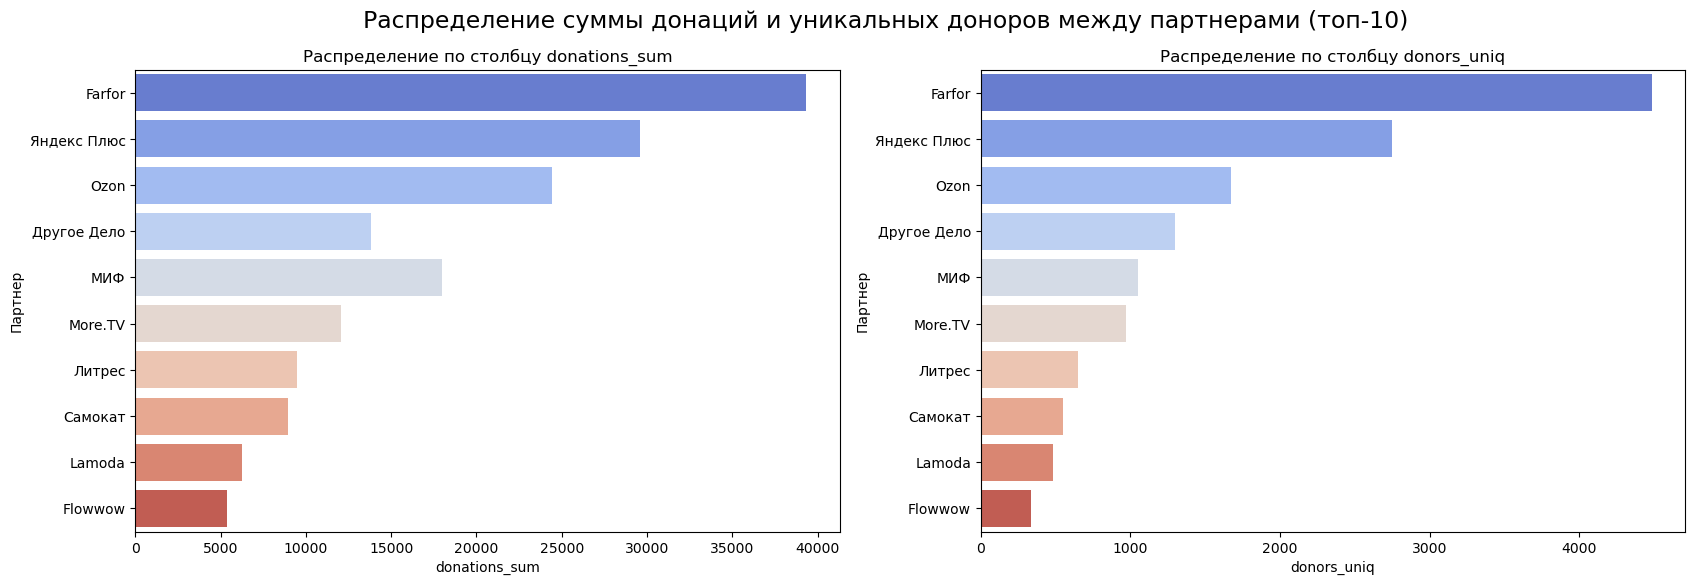

In [58]:
# Визуализация 10 самых популярных партнеров по сумме донаций и количеству уникальных доноров

fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.suptitle('Распределение суммы донаций и уникальных доноров между партнерами (топ-10)', fontsize=17)

for i, column in enumerate(['donations_sum', 'donors_uniq']):
    plt.subplot(1, 2, i+1)
    sns.barplot(data=partner_all, y=partner_all['partner'], x=partner_all[column], orient='h', palette='coolwarm')
    plt.ylabel("Партнер")
    plt.title(f'Распределение по столбцу {column}');

---
10 лидеров по популярности за весь период наблюдений (с января 2021 года):
- Farfor
- Яндекс Плюс
- Ozon 
- МИФ
- Другое Дело
- More.TV
- Литрес
- Самокат
- Lamoda
- Flowwow

При этом среднее значение донаций на пользователя разнится: например, оно высоко у издательства МИФ и сервиса Самокат - это значит, что бонусами этих партнеров пользовались пользователи, у которых, в среднем, больше донаций. Обратная ситуация у лидера рейтинга Farfor, его бонусами пользовались пользователи, у которых в среднем меньше 9 донаций.

---

### Выявление партнеров, пользующихся наибольшей популярностью за 2023 год

In [59]:
# Сводная таблица - 10 самых популярных партнеров исходя из суммы донаций уникальных пользователей, 
# воспользовавшихся бонусами данного партнёра, за 2023 год

partner_2023 = (
    user_bonus
    .query("year_month.dt.year == 2023")
    .drop_duplicates(subset=['user_id', 'partner'])
    .groupby('partner')
    .agg({'donations_count':'sum', 'user_id':'count'})
    .reset_index()
    .sort_values(by=['user_id'], ascending=False)
    .rename(columns={'user_id':'donors_uniq', 'donations_count':'donations_sum'})
    .head(10)
    .reset_index(drop=True)
)

partner_2023['mean'] = partner_2023['donations_sum'] / partner_2023['donors_uniq']

partner_2023

,partner,donations_sum,donors_uniq,mean
0,Farfor,30066,3388,8.874262
1,Яндекс Плюс,14562,986,14.768763
2,Литрес,9499,652,14.569018
3,Другое Дело,6715,637,10.541601
4,Самокат,8953,553,16.189873
5,More.TV,6375,513,12.426901
6,МИФ,8028,397,20.221662
7,Flowwow,4202,264,15.916667
8,МТС Premium,3458,203,17.034483
9,Газпромнефть,3076,164,18.756098


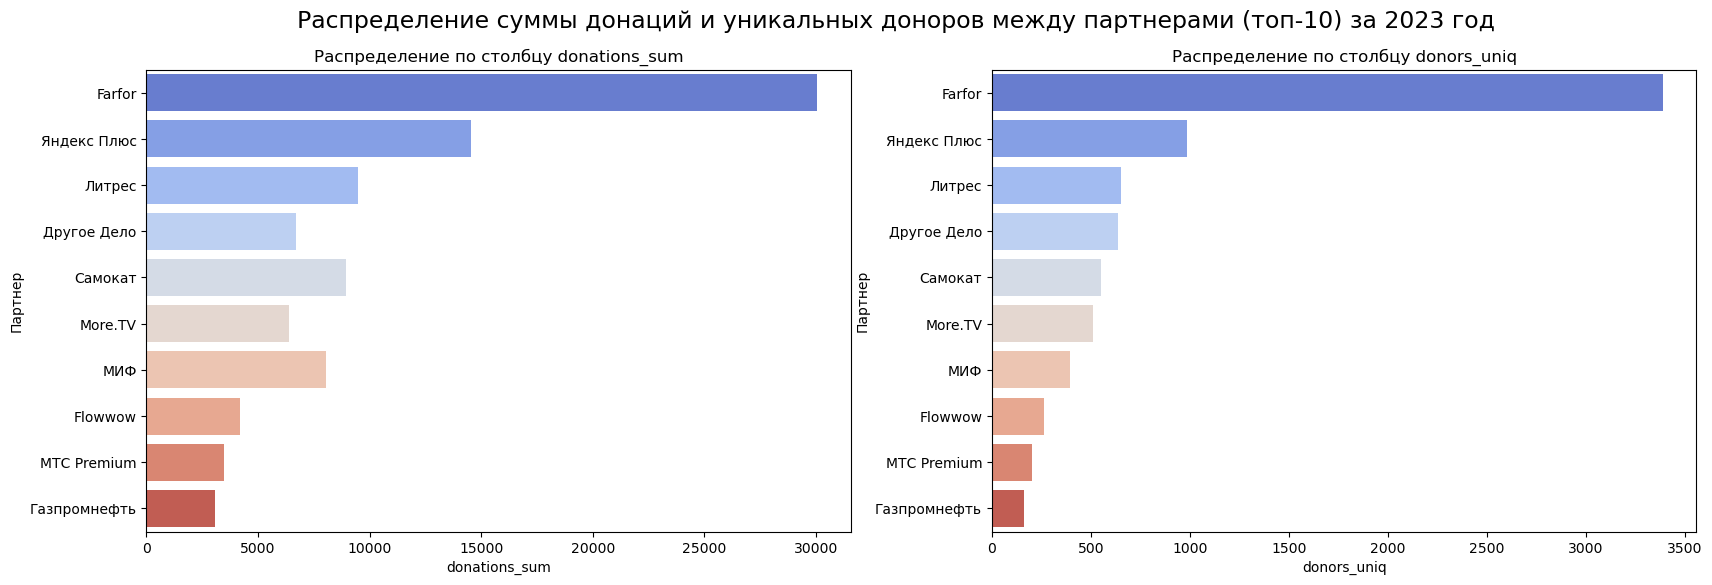

In [60]:
# Визуализация 10 самых популярных партнеров по сумме донаций и количеству уникальных доноров за 2023 год

fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=2)
fig.suptitle('Распределение суммы донаций и уникальных доноров между партнерами (топ-10) за 2023 год', fontsize=17)

for i, column in enumerate(['donations_sum', 'donors_uniq']):
    plt.subplot(1, 2, i+1)
    sns.barplot(data=partner_2023, y=partner_2023['partner'], x=partner_2023[column], orient='h', palette='coolwarm')
    plt.ylabel("Партнер")
    plt.title(f'Распределение по столбцу {column}');

---
Лидеры по популярности меняются, Farfor и Яндекс Плюс держат лидерство по популярности в 2023 году.

---

### Популярность партнеров за 2023 год в разрезе уникальных пользователей

In [61]:
# Сводная таблица с количеством уникальных пользователей по партнерам-лидерам 2023 года, по месяцам

partner_2023_monthly = (user_bonus
     .query("('2023-01' <= year_month <= '2023-10') & (partner in @partner_2023.partner)")
     .drop_duplicates(subset=['user_id', 'partner'])
     .pivot_table(index='year_month', columns='partner', values='user_id', aggfunc='nunique')
     .reset_index(names=['year_month'])
    )
partner_2023_monthly

partner,year_month,Farfor,Flowwow,More.TV,Газпромнефть,Другое Дело,Литрес,МИФ,МТС Premium,Самокат,Яндекс Плюс
0,2023-01,194.0,4.0,20.0,NaN,56.0,8.0,NaN,NaN,NaN,NaN
1,2023-02,480.0,34.0,33.0,NaN,83.0,98.0,NaN,NaN,NaN,NaN
2,2023-03,420.0,39.0,100.0,NaN,113.0,81.0,NaN,NaN,NaN,898.0
3,2023-04,403.0,29.0,79.0,NaN,78.0,87.0,NaN,NaN,NaN,88.0
4,2023-05,264.0,31.0,46.0,NaN,46.0,55.0,NaN,NaN,NaN,NaN
5,2023-06,229.0,31.0,53.0,NaN,46.0,64.0,66.0,NaN,93.0,NaN
6,2023-07,208.0,17.0,51.0,NaN,45.0,NaN,181.0,NaN,134.0,NaN
7,2023-08,269.0,22.0,49.0,NaN,51.0,7.0,100.0,10.0,105.0,NaN
8,2023-09,379.0,25.0,33.0,80.0,50.0,145.0,NaN,111.0,101.0,NaN
9,2023-10,457.0,28.0,40.0,67.0,53.0,90.0,50.0,63.0,91.0,NaN


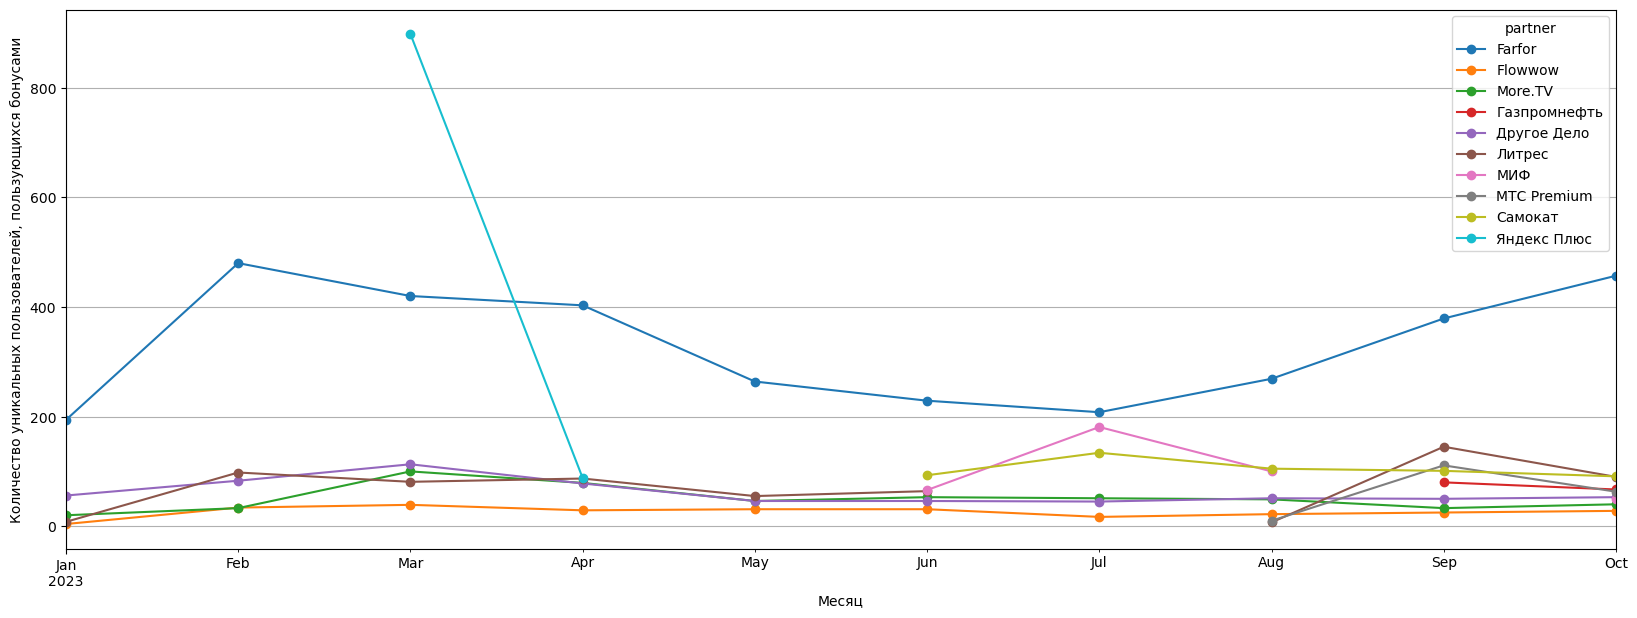

In [62]:
# Линейный график по сводной таблице

partner_2023_monthly.plot(x='year_month', grid=True, figsize=(20, 7), style='o-')
plt.xlabel("Месяц");
plt.ylabel("Количество уникальных пользователей, пользующихся бонусами");

---
Далеко не все партнёры из топ-10 по популярности за 2023 год были партнерами до этого.
Сам факт их попадания в топ-10 за год, как можно предположить, говорит об их востребованности у пользователей сайта.

В частности, по графику хорошо заметно, что Яндекс Плюс, который стал партнером в 2023 году и пробыл им всего месяц, имел огромную популярность и за этот короткий срок обеспечил себе место в топ-10. То же, но в меньшей степени, касается партнера издательства МИФ, сервиса Самокат, МТС Premium и Газпромнефти.

При этом следует отметить, что у этих новых партнеров, ставших таковыми в 2023 году, высокие средние значения донаций на пользователя, то есть, они пользуются популярностью у самых активных доноров. Можно сделать предположение об их перспективности.


---

### Популярность партнеров за последний квартал в разрезе уникальных пользователей

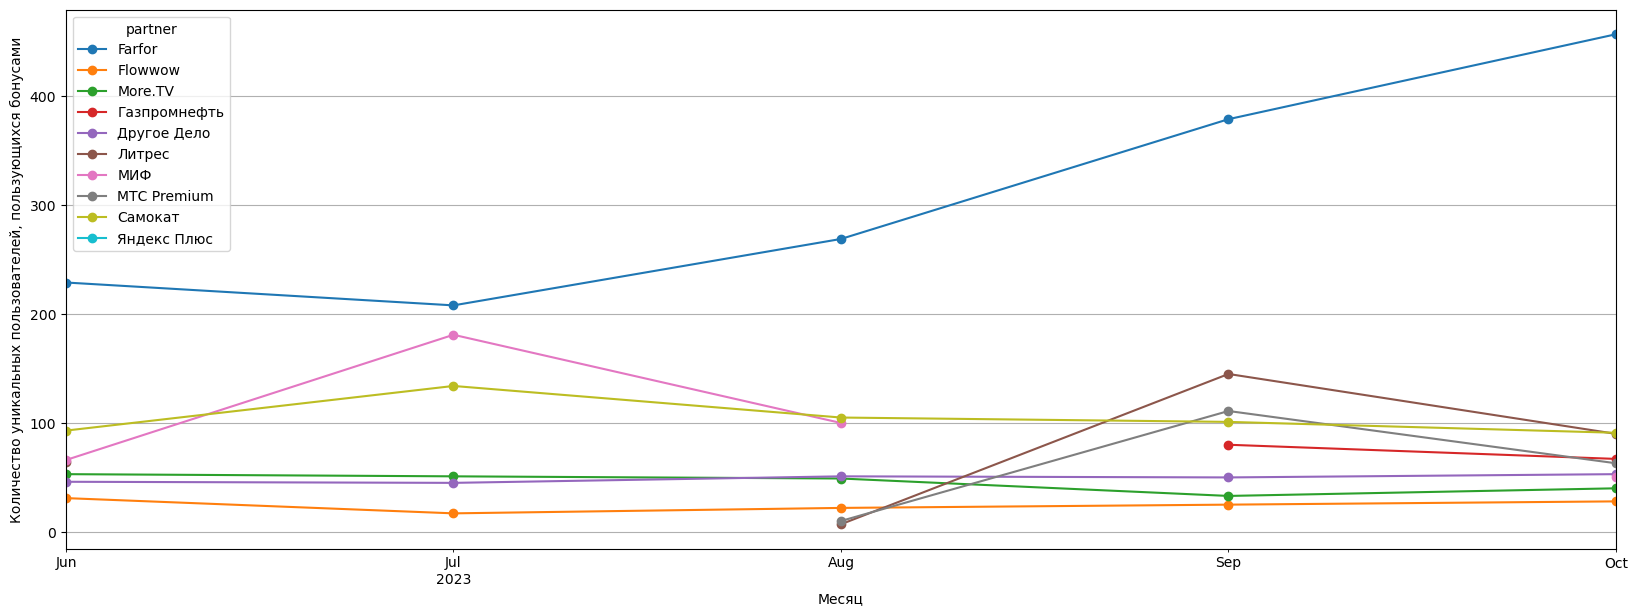

In [63]:
# Линейный график по сводной таблице

partner_2023_monthly.query("('2023-06' <= year_month)").plot(x='year_month', grid=True, figsize=(20, 7), style='o-')
plt.xlabel("Месяц");
plt.ylabel("Количество уникальных пользователей, пользующихся бонусами");

---
Устойчивый рост популярности за последний квартал (и за год в целом) демонстрирует Farfor.

Стабильна популярность у Flowwow, Другое дело и More.TV.

Новые партнеры MTC Premium, Литрес и Самокат сразу вышли в топ-10, однако для оценки динамики их популярности следует провести анализ спустя еще полгода, с учетом того, что данные за ноябрь и даже за октябрь 2023 года в датасете неполные.

---

### Вывод

---
Исходя из проведенного анализа можно сделать следующие основные выводы:
- абсолютным лидером по популярности является партнер Farfor, и востребованность его бонусов продолжает расти (при том, что средняя активность доноров, пользующихся его бонусами, ниже, чем у других партнеров из топ-10);
- за 2023 год (на момент анализа) был привлечен ряд новых партнёров, которые сразу же набрали высокую популярность и вошли в топ-10: это Яндекс Плюс, МИФ, Самокат, Газпромнефть, Литрес, МТС Premium;
- Яндекс Плюс и МИФ, судя по записям, перестали быть партнерами; при этом, их популярность столь высока, что их партнёрство желательно для привлечения доноров;
- Самокат, Газпромнефть, Литрес, МТС Premium (как и упомянутые Яндекс Плюс и МИФ) пользуются популярностью среди активных доноров (с большим средним количеством донаций на человека) и, таким образом, являются перспективными партнёрами.
---

## 3. Процент доноров, воспользовавшихся бонусами, от общего количества зарегистрировавшихся активных доноров

---
Вычисляем процент доноров, воспользовавшихся бонусами, от общего количества зарегистрировавшихся активных доноров, за весь период

---

In [64]:
print(f"Процент доноров, воспользовавшихся бонусами, от общего количество доноров (с подтвержденными донациями),\
 за весь период: {len(user_bonus['user_id'].unique()) / len(users[users['donations_confirmed'] > 0]):.2%}")


Процент доноров, воспользовавшихся бонусами, от общего количество доноров (с подтвержденными донациями), за весь период: 25.05%


---
Вычисляем процент доноров, воспользовавшихся бонусами, от общего количества зарегистрировавшихся активных доноров, по месяцам

---

In [65]:
list1 = {}
for month in user_bonus['year_month'].unique():
    list1[month] = user_bonus.query("year_month <= @month")['user_id'].nunique()
    
s = pd.DataFrame.from_dict(list1, orient='index', columns=['donors_bonus']).sort_values(by='donors_bonus', ascending=False).reset_index()

In [66]:
list2 = {}
for month in s['index']:
    list2[month] = users.query("(reg_date.dt.to_period('M') <= @month) & (donations_confirmed > 0)")['user_id'].nunique()
    
p = pd.DataFrame.from_dict(list2, orient='index', columns=['donors_total']).sort_values(by='donors_total', ascending=False).reset_index()

In [67]:
table = s.merge(p, on='index')

In [68]:
table['percent'] = round(table['donors_bonus'] / table['donors_total'], 4) * 100

table

,index,donors_bonus,donors_total,percent
0,2023-11,9173,36612,25.05
1,2023-10,9077,36285,25.02
2,2023-09,8702,35789,24.31
3,2023-08,8439,35310,23.90
4,2023-07,8104,34878,23.24
5,2023-06,7787,34467,22.59
6,2023-05,7493,34021,22.02
7,2023-04,7204,33495,21.51
8,2023-03,6714,32762,20.49
9,2023-02,5872,31663,18.55


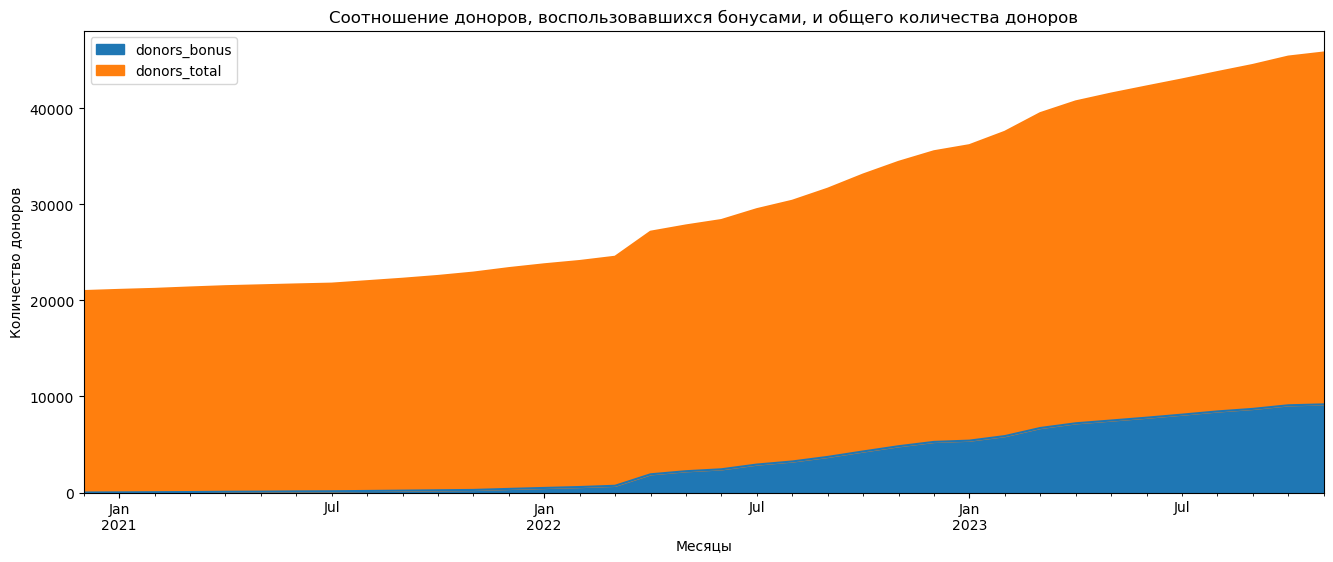

In [69]:
table[['index', 'donors_bonus', 'donors_total']].plot(kind="area", x='index', stacked=True, figsize=(16,6))
plt.title("Соотношение доноров, воспользовавшихся бонусами, и общего количества доноров")
plt.xlabel("Месяцы")
plt.ylabel("Количество доноров");


### Вывод

---
Рост количества пользователей и пользователей, пользующихся бонусами, происходит одновременно и достаточно симметрично.

На графике хорошо заметен всплеск обоих показателей с марта по апрель 2022 года, и дальнейшая интенсификация их роста.

---

## 4. Анализ всплеска количества пользователей и пользователей, пользующихся бонусами, с марта по апрель 2022 года (проверка гипотезы "Увеличение количества доноров с появлением бонуса - Яндекс Плюс")

---
Создадим сводную таблицу с наиболее популярными партнерами (по количеству уникальных пользователей, пользующихся их бонусами, и сумме их донаций), за интересующий период с ноября 2021 по ноябрь 2022 годов.

---

In [70]:
# Сводная таблица - 10 самых популярных партнеров с ноября 2021 по ноябрь 2022 годов

partner_2022 = (
    user_bonus
    .query("('2021-11' <= year_month <= '2022-11')")
    .drop_duplicates(subset=['user_id', 'partner'])
    .groupby('partner')
    .agg({'donations_count':'sum', 'user_id':'count'})
    .reset_index()
    .sort_values(by=['user_id'], ascending=False)
    .rename(columns={'user_id':'donors_uniq', 'donations_count':'donations_sum'})
    .head(10)
    .reset_index(drop=True)
)

partner_2022['mean'] = partner_2022['donations_sum'] / partner_2022['donors_uniq']

partner_2022

,partner,donations_sum,donors_uniq,mean
0,Яндекс Плюс,20975,2029,10.337605
1,Ozon,21504,1491,14.422535
2,Farfor,14765,1280,11.535156
3,МИФ,11571,706,16.389518
4,Другое Дело,7468,631,11.835182
5,More.TV,5616,431,13.030162
6,Lamoda,4683,373,12.554960
7,Utair,3436,171,20.093567
8,Ornament.health,2211,152,14.546053
9,Квиз Эйнштейн Party,1941,136,14.272059


---
Создаем сводную таблицу с количеством уникальных пользователей, пользующихся их бонусами, по топ-10 партнерам с ноября 2021 по ноябрь 2022 годов по месяцам

---

In [71]:
partner_2022_monthly = (user_bonus
     .query("('2021-11' <= year_month <= '2022-11') & (partner in @partner_2022.partner)")
     .drop_duplicates(subset=['user_id', 'partner'])
     .pivot_table(index='year_month', columns='partner', values='user_id', aggfunc='nunique')
     .reset_index(names=['year_month'])
    )
partner_2022_monthly

partner,year_month,Farfor,Lamoda,More.TV,Ornament.health,Ozon,Utair,Другое Дело,Квиз Эйнштейн Party,МИФ,Яндекс Плюс
0,2021-11,NaN,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12,NaN,11.0,8.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN
2,2022-01,NaN,14.0,NaN,2.0,NaN,NaN,NaN,NaN,72.0,NaN
3,2022-02,NaN,21.0,8.0,21.0,NaN,NaN,4.0,NaN,47.0,NaN
4,2022-03,NaN,15.0,8.0,11.0,48.0,NaN,33.0,NaN,7.0,NaN
5,2022-04,NaN,77.0,69.0,29.0,66.0,NaN,136.0,NaN,104.0,832.0
6,2022-05,NaN,32.0,25.0,16.0,203.0,NaN,55.0,NaN,48.0,200.0
7,2022-06,NaN,25.0,19.0,8.0,146.0,NaN,123.0,24.0,37.0,6.0
8,2022-07,2.0,35.0,35.0,14.0,206.0,62.0,53.0,112.0,49.0,730.0
9,2022-08,185.0,27.0,30.0,10.0,133.0,29.0,12.0,NaN,33.0,261.0


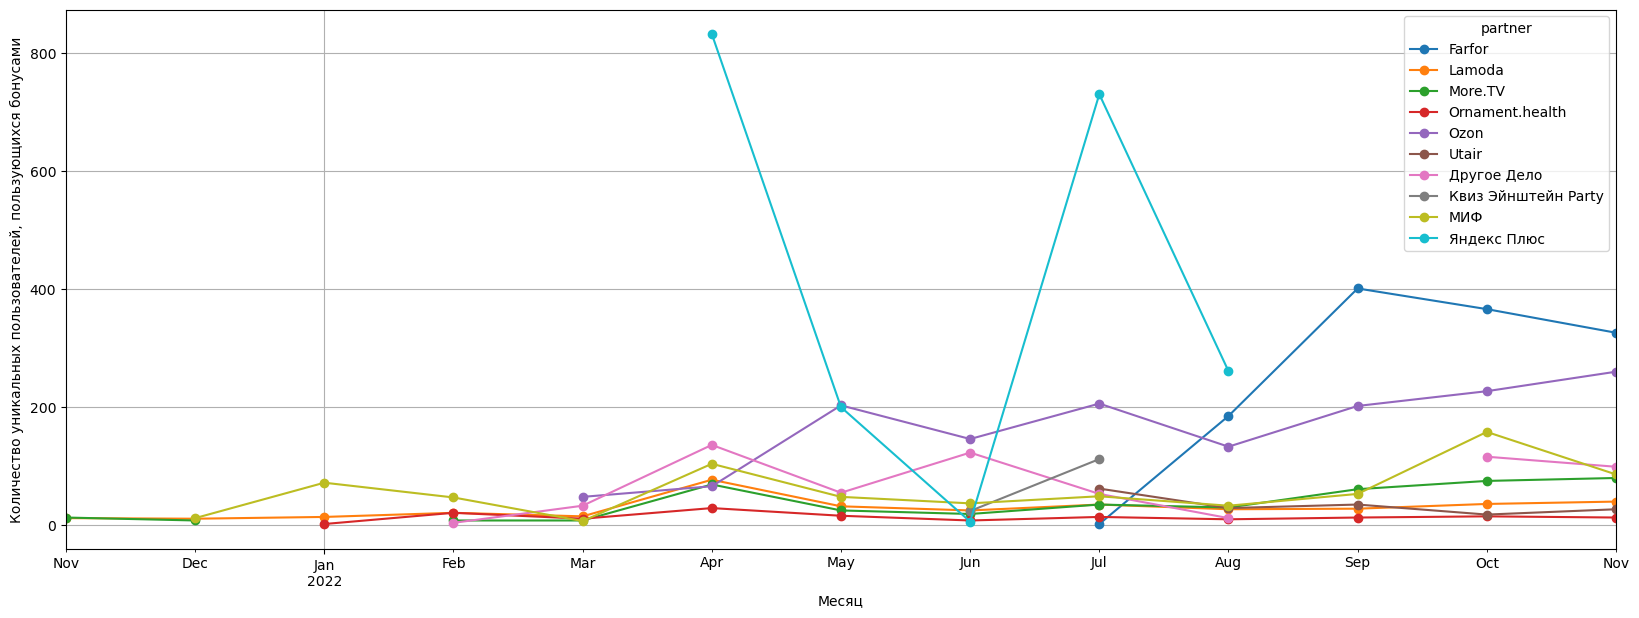

In [72]:
# Строим линейный график по сводной таблице

partner_2022_monthly.plot(x='year_month', grid=True, figsize=(20, 7), style='o-')
plt.xlabel("Месяц");
plt.ylabel("Количество уникальных пользователей, пользующихся бонусами");
plt.savefig('donors_dyn_awf.png', bbox_inches = 'tight')

## Вывод
---
Исходя из расчета количества доноров и количества доноров, пользующихся бонусами, всплеск обоих показателей произошел в апреле 2022.

Из анализа можно сделать следующие предположения:
- резкий рост количества доноров, пользующихся бонусами, и активных доноров в целом, в апреле 2022 года связан с подключением нового партнера Яндекс Плюс;
- вместе с тем, с начала 2022 года работа по привлечению партнеров начала по-настоящему приносить результаты, мы видим быстрое увеличение количества популярных партнеров (в т.ч. Ozon, МИФ, Farfor, More.TV);
- дальнейшее увеличение количества доноров, пользующихся бонусами, и активных доноров в целом, связано с **совокупностью этих двух факторов**.

Таким образом, гипотеза "Увеличение количества доноров с появлением бонуса - Яндекс Плюс" **подтверждается частично**.

---

## 5. Проверка гипотезы "пользователи из регионов менее вовлечены в сдачу крови чем жители столицы и областных центров"

### Загрузка информации о численности постоянного населения Российской Федерации по муниципальным образованиям на 1 января 2023 года, сформированной с использованием сервиса showdata.gks.ru

In [73]:
# Загрузка информации о численности постоянного населения Российской Федерации по муниципальным образованиям на 1 января 2023 года
# сформированная с использованием сервиса showdata.gks.ru


region_population = pd.read_excel('\\population.xlsx')

In [74]:
region_population.info()
region_population.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   region      84 non-null     object
 1   population  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


,region,population
0,Белгородская область,1514527
1,Брянская область,1152505
2,Владимирская область,1325510


### Загрузка информации о численности постоянного населения административных центров регионов Российской Федерации на 1 января 2023 года, сформированной с использованием сервиса showdata.gks.ru

In [75]:
region_center_population = pd.read_excel('\\reg_center_pop.xlsx')

In [76]:
region_center_population.info()
region_center_population.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        83 non-null     object
 1   population  83 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


,city,population
0,Белгород,333931
1,Брянск,375669
2,Владимир,346771


### Подготовка сегментов для анализа 

---
Создание столбца в датафрейме users, содержащего название населенного пункта

---

In [77]:
users['city'] = users['location'].str.split(r',\s*').str[2]

users['city'] = users['city'].fillna('Не указано')

---
Заполнение пропусков в строках с регионами Москва и Санкт-Петербург

---

In [78]:
users['city'] = np.where(users['region'] == 'Москва', 'Москва', users['city'])
users['city'] = np.where(users['region'] == 'Санкт-Петербург', 'Санкт-Петербург', users['city'])

---
Создание столбца loc_type с кодами сегментов:
- region_center - административный центр региона (кроме Москвы и Санкт-Петербурга)
- msk_spb - Москва и Санкт-Петербург
- region - регион (кроме административного центра, Москвы и Санкт-Петербурга)

---

In [79]:
center_list = (
    ['Гатчина', 'Кемерово', 'Ханты-Мансийск', 'Уфа', 'Архангельск', 'Новосибирск', 'Симферополь', 'Воронеж',
     'Брянск', 'Тюмень', 'Казань', 'Якутск', 'Черкесск', 'Волгоград', 'Киров', 'Смоленск', 'Краснодар', 'Челябинск', 'Ульяновск',
     'Ростов-на-Дону', 'Сыктывкар', 'Хабаровск', 'Калининград', 'Мурманск', 'Иваново', 'Саратов', 'Южно-Сахалинск', 'Махачкала',
     'Екатеринбург', 'Барнаул', 'Тверь', 'Иркутск', 'Пермь', 'Благовещенск', 'Нижний Новгород', 'Томск', 'Самара', 'Ярославль',
     'Белгород', 'Рязань', 'Орёл', 'Вологда', 'Элиста', 'Владимир', 'Красноярск', 'Владивосток', 'Ижевск', 'Оренбург', 'Тула',
     'Салехард', 'Омск', 'Астрахань', 'Петропавловск-Камчатский', 'Липецк', 'Великий Новгород', 'Калуга', 'Тамбов', 'Пенза',
     'Йошкар-Ола', 'Запорожье', 'Грозный', 'Курск', 'Абакан', 'Донецк', 'Петрозаводск', 'Улан-Удэ', 'Псков', 'Ставрополь',
     'Курган', 'Саранск', 'Чебоксары', 'Кострома', 'Луганск', 'Магадан', 'Чита', 'Кызыл', 'Биробиджан', 'Нальчик', 'Майкоп',
     'Нарьян-Мар', 'Владикавказ', 'Магас', 'Анадырь', 'Горно-Алтайск', 'Херсон']
    )

def reg(city):
    if city in center_list:
        return 'region_center'
    elif (city == 'Москва') | (city == 'Санкт-Петербург'):
        return 'msk_spb'
    elif (city not in center_list) & (city != 'Москва') & (city != 'Санкт-Петербург'):
        return 'region'
    else:
        return 'Не указано'

users['loc_type'] = users['city'].apply(reg)

In [80]:
users['loc_type'].value_counts()

region_center    66514
msk_spb          50895
region           30099
Name: loc_type, dtype: int64

### Формирование сводной таблицы с количеством активных доноров и суммой донаций по сегментам

In [81]:
# Исключаем из анализа ряд областей, поскольку нет сведений об их населении
exclude = ['Херсонская область', 'Луганская область', 'Донецкая область', 'Запорожская область']

# Создаем сводную таблицу с количеством активных доноров и суммой донаций по сегментам
grouped = (
    users
    .query("(donations_confirmed > 0) & (region not in @exclude)")
    .groupby('loc_type')
    .agg({'user_id':'nunique', 'donations_confirmed':'sum'})
    .reset_index()
    .rename(columns={'user_id':'donors', 'donations_confirmed':'donations_sum'})
    )
grouped

,loc_type,donors,donations_sum
0,msk_spb,9308,54669
1,region,7885,51209
2,region_center,19202,109700


### Дополнение сводной таблицы сведениями о населении 

---
Дополняем сводную таблицу сведениями о населении. Из населения регионов вычитаем население административных центров.

---

In [82]:
def l_t(loc_type):
    msk_spb_pop = region_population.query("region in ['Москва', 'Санкт-Петербург']")['population'].sum()
    reg_cen_pop = region_center_population.query("city not in ['Москва', 'Санкт-Петербург']")['population'].sum()
    reg_pop = region_population.query("region not in ['Москва', 'Санкт-Петербург']")['population'].sum()
    if loc_type == 'msk_spb':
        return msk_spb_pop
    elif loc_type == 'region_center':
        return reg_cen_pop
    elif loc_type == 'region':
        return reg_pop - reg_cen_pop
    else:
        return 'Не указано'

grouped['population_sum'] = grouped['loc_type'].apply(l_t)

grouped

,loc_type,donors,donations_sum,population_sum
0,msk_spb,9308,54669,18704221
1,region,7885,51209,87093935
2,region_center,19202,109700,40090995


---
Для нормализации показателей формируем столбцы с расчетом по каждому сегменту:
- количества активных доноров на 1000 человек населения;
- суммы донаций на 1000 человек населения.

---

In [83]:
grouped['donors_per_1000'] = grouped['donors'] / (grouped['population_sum'] / 1000)
grouped['donations_per_1000'] = grouped['donations_sum'] / (grouped['population_sum'] / 1000)
grouped

,loc_type,donors,donations_sum,population_sum,donors_per_1000,donations_per_1000
0,msk_spb,9308,54669,18704221,0.497642,2.922816
1,region,7885,51209,87093935,0.090534,0.587974
2,region_center,19202,109700,40090995,0.478960,2.736275


---
Из таблицы видно, что количество активных доноров и донаций на 1000 человек близко в Москве, Санкт-Петербурге и административных центрах регионов. В регионах этот показатель существенно ниже.

---

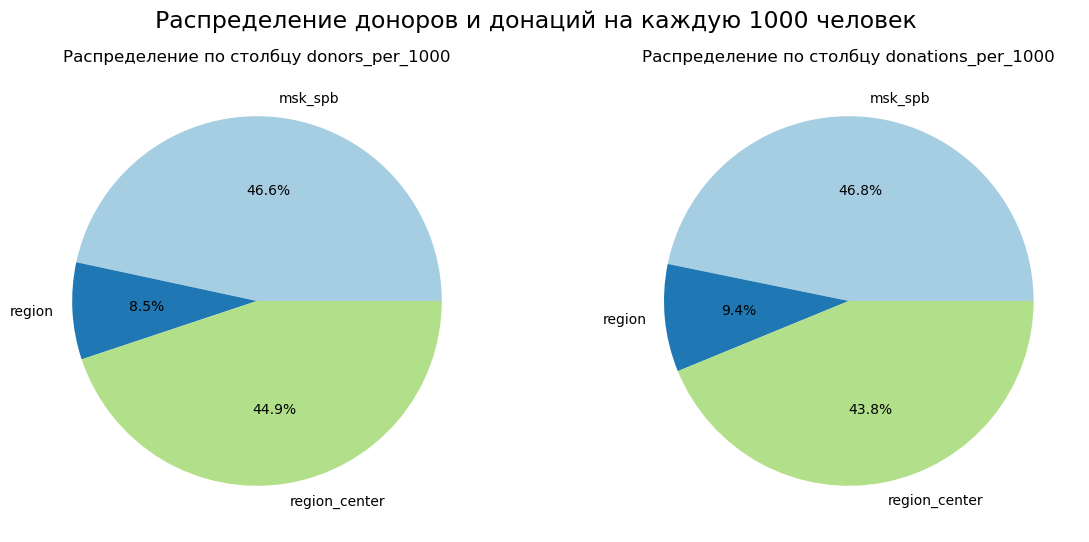

In [84]:
# Визуализируем соотношение количества активных доноров и донаций на 1000 человек в сегментах

current_palette = sns.color_palette("Paired")

fig, ax = plt.subplots(figsize=(14,6), nrows=1, ncols=2)
fig.suptitle('Распределение доноров и донаций на каждую 1000 человек', fontsize=17)

for i, column in enumerate(['donors_per_1000', 'donations_per_1000']):
    plt.subplot(1, 2, i+1)
    plt.pie(grouped[column], labels=grouped['loc_type'], autopct='%.1f%%', colors=current_palette)
    plt.title(f'Распределение по столбцу {column}');

### Анализ распределения центров сдачи крови 

In [85]:
# Загружаем датафрейм с центрами крови

blood_centers = pd.read_csv('C:\\Users\\pavli\\Documents\\DonorSearch\\output_blood_centers.csv')

In [86]:
blood_centers.info()
blood_centers.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   blood_center_id  1065 non-null   int64 
 1   city             1065 non-null   object
 2   country          1065 non-null   object
 3   donations_added  1065 non-null   int64 
 4   donors_count     1065 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 41.7+ KB


,blood_center_id,city,country,donations_added,donors_count
0,633,Москва,Россия,10037,1263
1,880,Казань,Россия,6931,589
2,366,Уфа,Россия,6681,1250


In [87]:
# Загружаем датафрейм с рейтингом центров крови

blood_centers_rating = pd.read_csv('C:\\Users\\pavli\\Documents\\DonorSearch\\output_blood_centers_rating.csv')

In [88]:
blood_centers_rating.info()
blood_centers_rating.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   blood_center         460 non-null    object 
 1   average_user_rating  460 non-null    float64
 2   ratings_count        460 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ KB


,blood_center,average_user_rating,ratings_count
0,Не указано,4.665698,1032
1,ГАУЗ «Республиканский центр крови Министерства...,4.734255,651
2,"ФГБУ НМИЦ Гематологии, (бывш. ГНЦ)",4.711507,617


In [89]:
# Создаем в датафрейме с центрами сдачи крови столбец code с сегментами для анализа

blood_centers['code'] = blood_centers['city'].apply(reg)

In [90]:
blood_centers.head()

,blood_center_id,city,country,donations_added,donors_count,code
0,633,Москва,Россия,10037,1263,msk_spb
1,880,Казань,Россия,6931,589,region_center
2,366,Уфа,Россия,6681,1250,region_center
3,838,Казань,Россия,6376,1469,region_center
4,571,Нижневартовск,Россия,5423,260,region


In [91]:
# Сводная таблица с общим количеством центров сдачи крови по сегментам

bc = blood_centers.groupby(['code']).agg({'blood_center_id':'nunique'}).reset_index()
bc

,code,blood_center_id
0,msk_spb,63
1,region,803
2,region_center,199


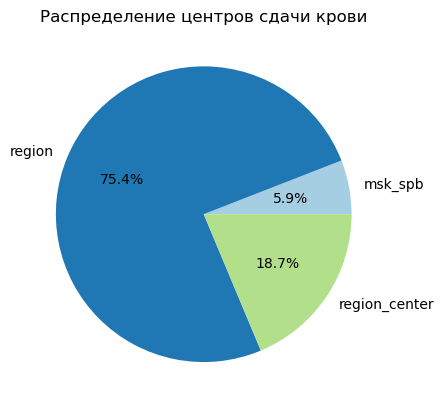

In [92]:
# График с распределением количества центров крови по сегментам

plt.pie(bc['blood_center_id'], labels=bc['code'], autopct='%.1f%%', colors=current_palette)
plt.title(f'Распределение центров сдачи крови');

In [93]:
# Соединяем таблицы с количеством центров сдачи крови - и с населением

grouped = grouped.merge(bc, left_on='loc_type', right_on='code', how='outer')
grouped

,loc_type,donors,donations_sum,population_sum,donors_per_1000,donations_per_1000,code,blood_center_id
0,msk_spb,9308,54669,18704221,0.497642,2.922816,msk_spb,63
1,region,7885,51209,87093935,0.090534,0.587974,region,803
2,region_center,19202,109700,40090995,0.478960,2.736275,region_center,199


In [94]:
grouped['centers_per_1000'] = grouped['blood_center_id'] / (grouped['population_sum'] / 1000)
grouped

,loc_type,donors,donations_sum,population_sum,donors_per_1000,donations_per_1000,code,blood_center_id,centers_per_1000
0,msk_spb,9308,54669,18704221,0.497642,2.922816,msk_spb,63,0.003368
1,region,7885,51209,87093935,0.090534,0.587974,region,803,0.009220
2,region_center,19202,109700,40090995,0.478960,2.736275,region_center,199,0.004964


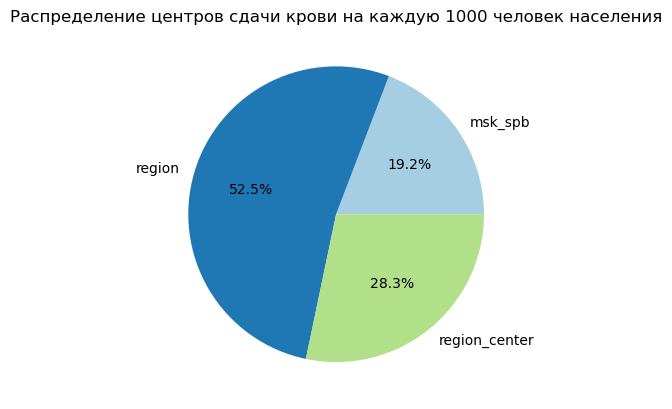

In [95]:
# График с распределением количества центров крови на каждую 1000 человек населения, по сегментам

plt.pie(grouped['centers_per_1000'], labels=grouped['loc_type'], autopct='%.1f%%', colors=current_palette)
plt.title(f'Распределение центров сдачи крови на каждую 1000 человек населения');
plt.savefig('reg_inv_cent.png', bbox_inches = 'tight')

### Вывод
---
Количество активных доноров и донаций на 1000 человек в Москве, Санкт-Петербурге и административных центрах регионов очень близко. В регионах этот показатель существенно ниже.

При этом, количество центров сдачи крови в регионах (на 1000 человек населения) практически равно таковому во взятых вместе Москве, Санкт-Петербурге и административных центрах регионов.

Таким образом, на имеющихся данных анализ **подтверждает гипотезу** о том, что пользователи из регионов менее вовлечены в сдачу крови чем жители столицы и областных центров.

---

## 6. Проверка гипотезы "чем выше медианная заработная плата в регионе - тем ниже количество доноров на 1000 человек"

### Загрузка информации о медианных зарплатах в регионах РФ на январь 2021 и январь 2023 годов, сформированной с использованием сервиса showdata.gks.ru

In [96]:
# Загрузка информации о медианных зарплатах в регионах РФ на январь 2021 и январь 2023 годов

wage = pd.read_excel('\\zp.xlsx')

In [97]:
wage.info()
wage.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       84 non-null     object 
 1   median_2021  84 non-null     float64
 2   median_2023  84 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.1+ KB


,region,median_2021,median_2023
0,Белгородская область,35371.99,45157.59
1,Брянская область,28874.00,38445.90
2,Владимирская область,33110.00,42997.49


### Загрузка информации о численности постоянного населения Российской Федерации по муниципальным образованиям на 1 января 2023 года, сформированной с использованием сервиса showdata.gks.ru

### Формирование сводной таблицы


Подготовка сводной таблицы с информацией о количестве уникальных активных доноров (доноры, у которых более одной подтвержденной донации) по регионам.


In [100]:
users_region = users.query("donations_confirmed > 0").groupby('region')['user_id'].nunique().reset_index().rename(columns={'user_id':'donors'})
users_region.head()

,region,donors
0,Адыгея,37
1,Алтай,14
2,Алтайский край,350
3,Амурская область,336
4,Архангельская область,148



Присоединяем к сводной таблице с информацией о количестве уникальных активных доноров - таблиц с медианными зарплатами и с численностью населения



In [101]:
table = wage.merge(region_population, how='outer', left_on='region', right_on='region').merge(users_region, how='outer', left_on='region', right_on='region')
table

,region,median_2021,median_2023,population,donors
0,Белгородская область,35371.99,45157.59,1514527.0,333
1,Брянская область,28874.00,38445.90,1152505.0,330
2,Владимирская область,33110.00,42997.49,1325510.0,192
3,Воронежская область,32988.99,43367.50,2285282.0,479
4,Ивановская область,27343.00,34703.19,914725.0,424
...,...,...,...,...,...
83,Чукотский АО,95837.00,126429.09,47840.0,3
84,Донецкая область,NaN,NaN,NaN,93
85,Запорожская область,NaN,NaN,NaN,82
86,Луганская область,NaN,NaN,NaN,25


In [102]:
# Убираем из сводной таблицы строки с регионами, по которым нет статистических данных, и где не менее 100 активных доноров

table = table.query("(~population.isna()) and (donors >= 100)")

In [103]:
table

,region,median_2021,median_2023,population,donors
0,Белгородская область,35371.99,45157.59,1514527.0,333
1,Брянская область,28874.00,38445.90,1152505.0,330
2,Владимирская область,33110.00,42997.49,1325510.0,192
3,Воронежская область,32988.99,43367.50,2285282.0,479
4,Ивановская область,27343.00,34703.19,914725.0,424
5,Калужская область,39141.00,47449.09,1070853.0,376
7,Курская область,31967.99,41792.69,1067034.0,171
8,Липецкая область,33518.99,44036.59,1126263.0,155
9,Московская область,51215.00,64173.19,8591736.0,1329
10,Орловская область,27887.99,38386.79,700276.0,168


Добавляем к сводной таблице столбец с информацией о количестве активных доноров на каждую 1000 человек в регионе

In [104]:
# Добавляем к сводной таблице столбец с информацией о количестве активных доноров на каждую 1000 человек в регионе

table['donors_per_1000'] = table['donors'] / (table['population'] / 1000)

table.head()

C:\Users\pavli\AppData\Local\Temp\ipykernel_7456\1616442122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['donors_per_1000'] = table['donors'] / (table['population'] / 1000)


,region,median_2021,median_2023,population,donors,donors_per_1000
0,Белгородская область,35371.99,45157.59,1514527.0,333,0.219871
1,Брянская область,28874.00,38445.90,1152505.0,330,0.286333
2,Владимирская область,33110.00,42997.49,1325510.0,192,0.144850
3,Воронежская область,32988.99,43367.50,2285282.0,479,0.209602
4,Ивановская область,27343.00,34703.19,914725.0,424,0.463527


### Проверка гипотезы


Сортировка сводной таблицы по убыванию медианной зарплаты по данным на январь 2023 года



In [105]:
table.sort_values(by='median_2023', ascending=False)

,region,median_2021,median_2023,population,donors,donors_per_1000
17,Москва,75728.99,92700.29,13104177.0,6202,0.473284
59,Ханты-Мансийский Автономный округ - Югра АО,68610.00,84923.50,1730353.0,597,0.345016
75,Саха /Якутия/,62830.99,83003.70,997565.0,102,0.102249
25,Мурманская область,58996.00,77594.39,658698.0,213,0.323365
28,Санкт-Петербург,58654.00,73541.39,5600044.0,3104,0.554281
9,Московская область,51215.00,64173.19,8591736.0,1329,0.154684
78,Хабаровский край,50197.00,63349.00,1284090.0,255,0.198584
19,Коми,48238.00,61615.70,726434.0,193,0.265681
77,Приморский край,47252.00,61378.99,1820076.0,278,0.152741
67,Красноярский край,45407.00,61252.59,2845545.0,933,0.327881


---
После сортировки невооруженному глазу заметно, что сильной корреляции между медианной зарплатой и количеством активных доноров на каждую 1000 человек в регионе - нет.

Проверим коэффициент корреляции Пирсона.

---

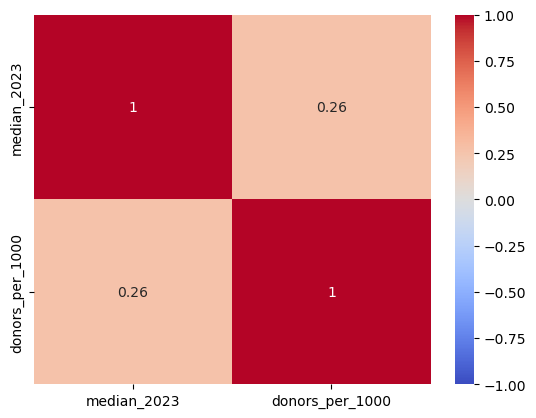

In [106]:
# Строим тепловую карту по коэффициентам корреляции Пирсона между значениями столбцов с медианной зарплатой
# и количеством активных доноров на каждую 1000 человек в регионе

sns.heatmap(table.drop(['region', 'median_2021', 'population', 'donors'], axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm');

---
Коэффициент корреляции Пирсона между значениями столбцов с медианной зарплатой и количеством активных доноров на каждую 1000 человек в регионе составляет 0,26 (максимально возможный коэффициент корреляции Пирсона составляет 1).

---

### Вывод

---
Применение коэффициента корреляции Пирсона к значениям столбцов с медианной зарплатой и количеством активных доноров на каждую 1000 человек в регионе (при условии, что в регионе есть хотя бы 100 и более активных доноров) выявило, что имеется положительная, но слабая корреляция.

Таким образом, гипотеза "чем выше медианная заработная плата в регионе - тем ниже количество доноров на 1000 человек" - **не нашла своего подтверждения** на имеющихся в распоряжении данных.

---